This notebook explores retrieving MUR Sea Surface Temperature (SST) grid data for the area of interest (Tampa), saving it as points to aggregate to scale 7 hexagons and saving as a raster to sample by hex scale 8 centroids. 

In [1]:
# Import all the required libraries
import geopandas
import pandas
import rioxarray
import rasterio
import xarray
import fsspec
import os
import h3
from shapely.geometry import shape, mapping

#also requires descartes
%matplotlib notebook

## Part 1: Retrieve the grid data

In [2]:
# Date to retrieve
day = '2019-06-01'

Read in Area of Interest from shapefile

In [3]:
repo_dir = os.path.join(os.getcwd(), 'temperature_data')
# Original source:
shp_aoi = os.path.join(repo_dir, 'TampaBay.shp')
gdf_aoi = geopandas.read_file(shp_aoi)
# Transform to GCS
gdf_aoi.to_crs(epsg=4269, inplace=True)

In [4]:
# Get extent in required format
bbox = gdf_aoi.total_bounds
minx, miny, maxx, maxy = bbox[0], bbox[1], bbox[2], bbox[3]

In [5]:
# MUR SST from AWS S3 bucket
file_location = 's3://mur-sst/zarr'
ikey = fsspec.get_mapper(file_location, anon=True)
ds_sst = xarray.open_zarr(ikey, consolidated=True)

sst = ds_sst['analysed_sst']

<IPython.core.display.Javascript object>


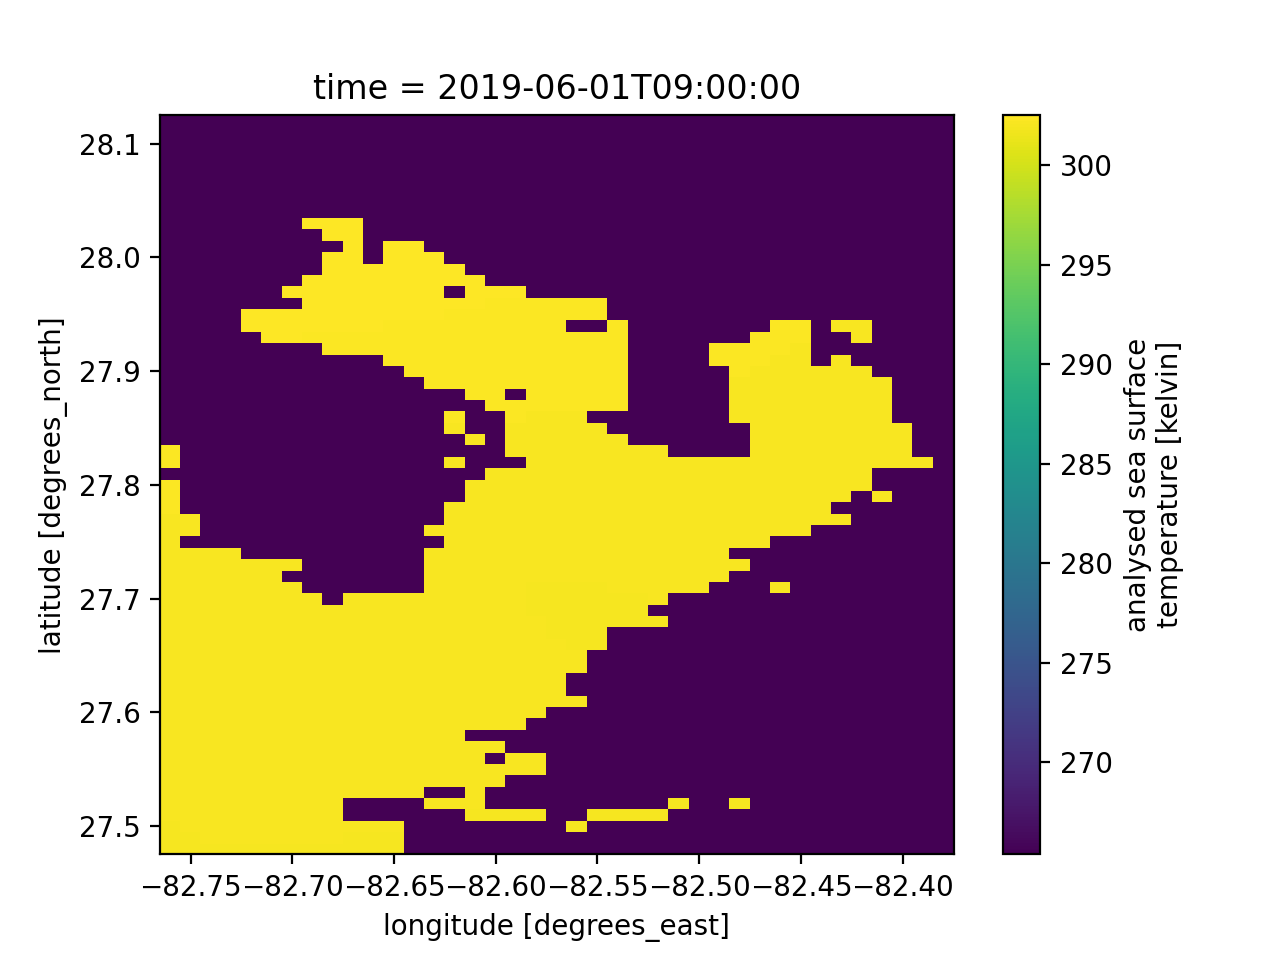

In [6]:
# Subset using extent and date
sst_masked = sst.sel(lat = slice(miny, maxy), lon = slice(minx, maxx))
sst_masked_day = sst_masked.sel(time=day)
sst_masked_day.plot()

## Part 2: Save dataset

Save dataset as raster tif

In [7]:
sst_day = sst_masked_day.rio.write_crs("epsg:4269")
tif = repo_dir + os.sep + 'sst_{}.tif'.format(day)
sst_day.rio.to_raster(tif)

In [8]:
rio = xarray.open_rasterio(tif)

Save dataset as points shapefile

In [9]:
# subset to geodataframe
df = sst_masked_day.to_dataframe()
df = df.reset_index()
gdf_sst = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))
gdf_sst = gdf_sst.drop(columns=['lon','lat'])

In [13]:
# Datetime field gives shp issues so we'll pass a schema dictionary
schema = {'geometry': 'Point',
          'properties': {'analysed_sst': 'float', 'time': 'date'}
          }
gdf_sst.to_file(repo_dir + os.sep + 'sst.shp', schema=schema)

In [14]:
# Drop land mask no-data value
gdf_sst = gdf_sst[gdf_sst['analysed_sst'] != 265.3819885253906]

## Part 2: Points to hexagons

In [15]:
def hex_idx(gdf, hexagon_size, method='count'):
    """ Point to hex by aggregating"""
    h3_idx_col = 'hex' + str(hexagon_size)
    # Assign hex ID
    gdf[h3_idx_col] = gdf.apply(lambda x: h3.geo_to_h3(x.geometry.y,
                                                       x.geometry.x,
                                                    hexagon_size), 1)
    # Aggregate into hexagons
    if method == 'avg':
        pnt_hex = gdf.groupby(h3_idx_col).mean()
    else:
        pnt_hex = gdf.groupby(h3_idx_col).size().to_frame('cnt')
    return pnt_hex.reset_index()


def boundary_geom(hex_id):
    '''Implement h3_to_geo_boundary in bulk'''
    return shape({'type': 'Polygon',
                  'coordinates': [h3.h3_to_geo_boundary(h=hex_id,
                                                        geo_json=True)]})

Aggregate points to hexagons

In [16]:
# Set the desired hexagon size (1-15)
hex_size = 7
hex_column = 'hex' + str(hex_size)
# Average temperatures if multiple centroids in a hexagon
hex_sst7 = hex_idx(gdf_sst, hex_size, 'avg')
# Add geometry to plot
hex_sst7['geom'] = hex_sst7[hex_column].apply(lambda x: boundary_geom(x))
gdf_hex_sst7 = geopandas.GeoDataFrame(hex_sst7, geometry='geom')

<IPython.core.display.Javascript object>


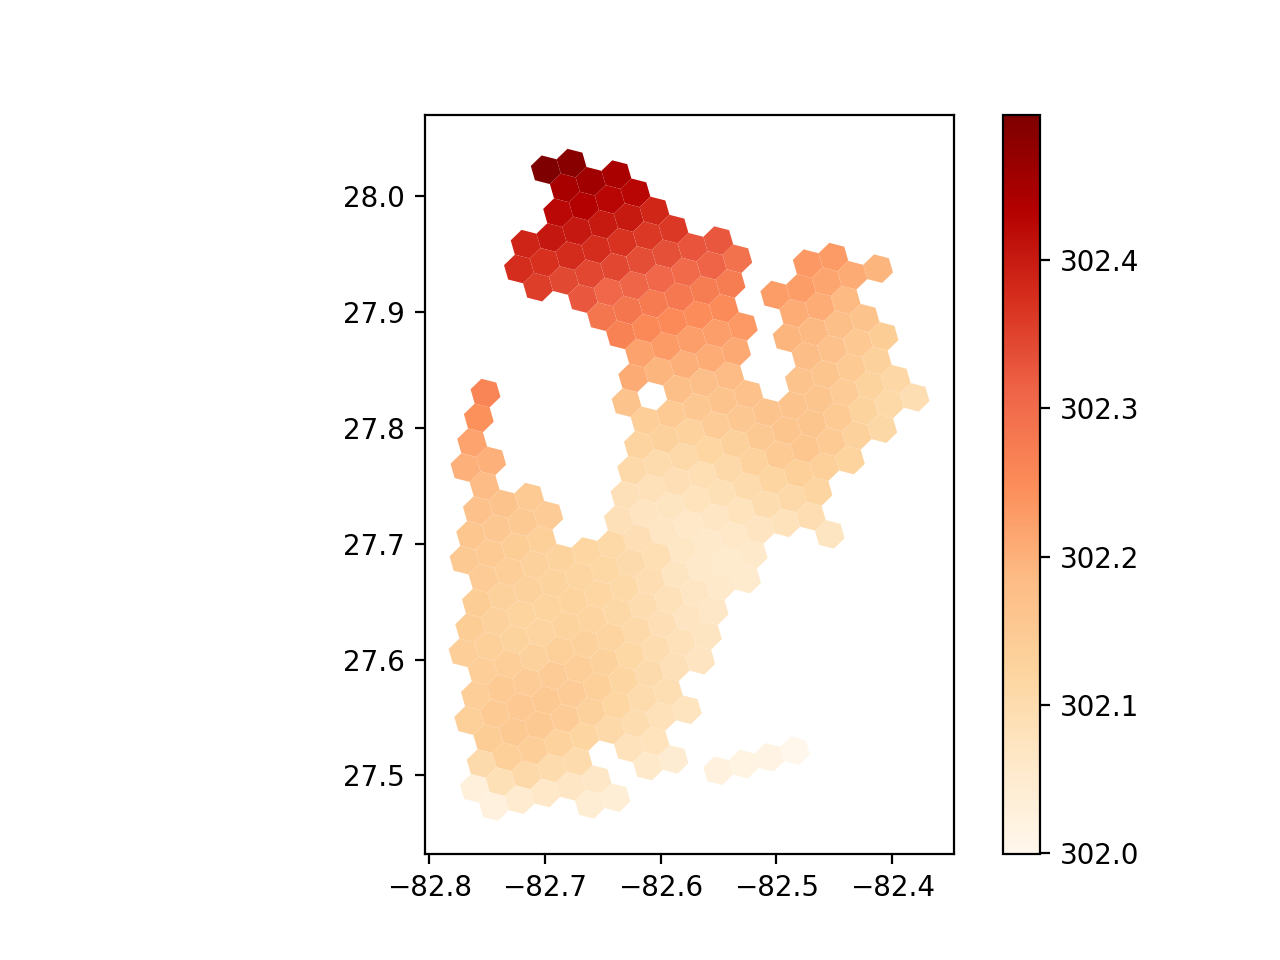

In [19]:
gdf_hex_sst7.plot(column='analysed_sst', cmap='OrRd', legend=True)

In [20]:
# Save as shapefile
gdf_hex_out7 = repo_dir + os.sep + 'hex{}_sst_{}.shp'.format(hex_size, day)
gdf_hex_sst7.to_file(gdf_hex_out7)

## Part 3: Raster to hexagon centeroid

In [21]:
def poly_hex_idx(gdf, hexagon_size):
    """ Polygon to hex by fill (only 1 polygon at a time)"""
    hex_col = 'hex' + str(hexagon_size)
    temp = mapping(gdf)  #shapely.mapping()
    temp_geo = temp['features'][0]['geometry']
    # Switch temp_geo x-y order and convert tuple to list
    coord = 'coordinates'
    temp_geo[coord] = [[(j[1], j[0]) for j in geo] for geo in temp_geo[coord]]
    # Create dataframe for polygon filled with hexagons
    hex_fill = pandas.DataFrame(h3.polyfill(temp_geo,
                                            hexagon_size),
                                columns=[hex_col])

    return hex_fill

Open raster

In [22]:
src = rasterio.open(tif)
#rasterio.plot.show(src)

Get points for hexagons

In [23]:
# Set the desired hexagon size (1-15)
hex_size = 8
hex_col = 'hex' + str(hex_size)
# Fill AOI with hexagons
aoi_fill = poly_hex_idx(gdf_aoi, hex_size)
# Assign points for each hex centroid
# aoi_hex_fill['lat'] = aoi_hex_fill[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
# aoi_hex_fill['lon'] = aoi_hex_fill[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
# gdf_sst = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))
aoi_fill['pnt_x'] = aoi_fill[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
aoi_fill['pnt_y'] = aoi_fill[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
aoi_hex_gdf = geopandas.GeoDataFrame(aoi_fill, geometry=geopandas.points_from_xy(aoi_fill.pnt_x, aoi_fill.pnt_y))

TO DO: Sample raster by centroids

In [ ]:
#aoi_hex_gdf['sst'] = [rasterio.sample.sample_gen(src, [(h3.h3_to_geo(x)[0], h3.h3_to_geo(x)[1])]) for x in aoi_hex_gdf[hex_col]]

In [ ]:
#aoi_hex_gdf['sst'][0]

In [ ]:
#aoi_hex_gdf['sst'] = [s[0] for s in src.sample([(h3.h3_to_geo(x)[0], h3.h3_to_geo(x)[1]) for x in aoi_hex_gdf[hex_col]])]

In [ ]:
#min(aoi_hex_gdf['sst'])

In [ ]:
#aoi_hex_gdf['sst'] = [[s[0] for s in src.sample((h3.h3_to_geo(x)[0], h3.h3_to_geo(x)[1]))] for x in aoi_hex_gdf[hex_col]]

In [ ]:
# Save as shapefile
gdf_hex_out8 = repo_dir + os.sep + 'hex{}_sst_{}.shp'.format(hex_size, day)
aoi_hex_gdf.to_file(gdf_hex_out8)